# Semantic Textual Similarity Project

**Authors**
- Kacper Poniatowski
- Pau Blanco

TODO: Include brief outline of project
- Context
- What were trying to achieve
- etc.

## Pre-Reqs

### Imports

In [91]:
# Force auto-reload
%load_ext autoreload
%autoreload 2

import pandas as pd
import nltk
import numpy as np
import os

from utils import load_data, evaluate_rf_model, drop_highly_correlated_features
from models import ModelTrainer
from feature_extraction import FeatureExtractor
from utils import save_predictions
from scipy.stats import pearsonr

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet_ic')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kacpe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Kacpe\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kacpe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Kacpe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kacpe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet_ic to
[nltk_data]     C:\Users\Kacpe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet_ic is already u

True

### Define Constants

In [92]:
# Define constant paths used throughout notebook
TRAIN_PATH = '../data/train/01_raw/'
TRAIN_GS_PATH = '../data/train/scores/'
TEST_PATH = '../data/test/01_raw/'
TEST_GS_PATH = '../data/test/scores/'
TRAIN_SAVE_PATH = '../data/train/02_preprocessed/preprocessed_train_data.csv'
TEST_SAVE_PATH = '../data/test/02_preprocessed/preprocessed_test_data.csv'
PREDICTED_SAVE_PATH = '../data/test/03_predicted/'

### Load Data

In [93]:
# Load train data
print('\n Loading train data')
all_train_files = ['SMTeuroparl', 'MSRvid', 'MSRpar']
df_train = load_data(TRAIN_PATH, TRAIN_GS_PATH, all_train_files)

# Load test data
print('\n Loading test data')
all_test_files = ['SMTeuroparl', 'MSRvid', 'MSRpar', 'surprise.OnWN', 'surprise.SMTnews']
df_test = load_data(TEST_PATH, TEST_GS_PATH, all_test_files)

print('\n Train and test datasets loaded successfully')


 Loading train data

 Loading test data

 Train and test datasets loaded successfully


### Extract Features

In [7]:
feature_extractor = FeatureExtractor()

# Extract the desired features
def add_features(dt):
    feature_extractor.add_POS_statistics(dt)
    feature_extractor.add_synset_statistics(dt)
    feature_extractor.add_lemma_statistics(dt)

# Add features to the training and test data
add_features(df_train)
add_features(df_test)

print('\n Features added to datasets successfully')

# Save df_train and df_test to respective files - this is done to avoid re-running the
# feature extraction process each time as synset extraction is computationally expensive
df_test.to_csv(TEST_SAVE_PATH, index=False)
df_train.to_csv(TRAIN_SAVE_PATH, index=False)

print('\n Train and test datasets saved as .csv files successfully')

Adding POS based features...
Adding synset-based features...
Processed 2233 of 2234 rows (100%)      
Adding lemma based features...
Adding POS based features...
Adding synset-based features...
Processed 3107 of 3108 rows (100%)      
Adding lemma based features...

 Features added to datasets successfully

 Train and test datasets saved as .csv files successfully


## Pearson Score Calculations

### Load Existing Dataframes

In [94]:
if TRAIN_SAVE_PATH is None or TEST_SAVE_PATH is None:
    raise ValueError('TRAIN_SAVE_PATH and TEST_SAVE_PATH must be defined')

if not os.path.exists(TRAIN_SAVE_PATH):
    raise FileNotFoundError(f'The file {TRAIN_SAVE_PATH} does not exist')

if not os.path.exists(TEST_SAVE_PATH):
    raise FileNotFoundError(f'The file {TEST_SAVE_PATH} does not exist')

original_df_train = pd.read_csv(TRAIN_SAVE_PATH)
original_df_test = pd.read_csv(TEST_SAVE_PATH)

print('\n Train and test datasets loaded from .csv files successfully')


 Train and test datasets loaded from .csv files successfully


### Perform Feature Selection

#### Correlation Matrix

In [95]:
# Drop first 4 columns to remove non-numerical columns
df_train = original_df_train.drop(original_df_train.columns[:4], axis=1)
df_test = original_df_test.drop(original_df_test.columns[:4], axis=1)

correlation_matrix = df_train.corr()
print(correlation_matrix)

# Total number of columns in the correlation matrix
total_cols = correlation_matrix.shape[1]
print(f'\n Total number of columns (features) in the correlation matrix: {total_cols}')

                           s1_n_words  s2_n_words  s1_n_verbs_tot  \
s1_n_words                   1.000000    0.918735        0.758300   
s2_n_words                   0.918735    1.000000        0.673713   
s1_n_verbs_tot               0.758300    0.673713        1.000000   
s2_n_verbs_tot               0.590479    0.698453        0.740191   
s1_n_verbs_pres              0.246101    0.191457        0.571911   
...                               ...         ...             ...   
lemma_lcs_length             0.814533    0.793255        0.545660   
lemma_edit_distance          0.781976    0.809274        0.570023   
proportion_s1_in_s2          0.202598    0.231090        0.077001   
proportion_s2_in_s1          0.298470    0.213312        0.158630   
lemma_position_similarity    0.153036    0.110382        0.118022   

                           s2_n_verbs_tot  s1_n_verbs_pres  s2_n_verbs_pres  \
s1_n_words                       0.590479         0.246101         0.113169   
s2_n_words   

#### Drop Highly Correlated Features

In [97]:
# Initial number of columns
total_cols = len(df_train.columns)

# Find columns to drop from df_train and df_test
dropped_columns = drop_highly_correlated_features(df_train)

df_train_trimmed = df_train.drop(columns=dropped_columns)
df_test_trimmed = df_test.drop(columns=dropped_columns)

# Statistics
print(f'\nNumber of features dropped: {len(dropped_columns)}')
print("Remaining features after dropping highly correlated ones:", df_train_trimmed.columns)
print(f'\nNumber of remaining features after dropping highly correlated ones: {len(df_train_trimmed.columns)}')
print(f'\nPercentage of features removed: {(total_cols - len(df_train_trimmed.columns)) / total_cols * 100:.2f}%')

# Print shape of df_test to verify consistency
print(f'\nShape of df_test after column removal: {df_test_trimmed.shape}')


Number of features dropped: 32
Remaining features after dropping highly correlated ones: Index(['s1_n_words', 's1_n_verbs_tot', 's2_n_verbs_tot', 's1_n_verbs_pres',
       's2_n_verbs_pres', 's1_n_verbs_past', 's2_n_verbs_past',
       's1_n_adjectives', 's1_n_adverbs', 's2_n_adverbs', 'dif_n_words',
       'dif_n_verbs_tot', 'dif_n_verbs_pres', 'dif_n_verbs_past',
       'dif_n_nouns', 'dif_n_adjectives', 'dif_n_adverbs', 'jaccard_all_words',
       'jaccard_verbs', 'jaccard_nouns', 'jaccard_adjectives',
       'jaccard_adverbs', 'all_all_shared_synsets_count',
       'all_all_avg_synset_similarity', 'all_verb_shared_synsets_ratio',
       'all_verb_avg_synset_similarity', 'all_verb_max_synset_similarity',
       'all_noun_shared_synsets_ratio', 'all_noun_avg_synset_similarity',
       'all_adj_shared_synsets_count', 'all_adj_shared_synsets_ratio',
       'all_adj_max_synset_similarity', 'all_adv_shared_synsets_count',
       'all_adv_shared_synsets_ratio', 'all_adv_max_synset_simila

In [98]:
# # Pull remaining feature column names from df into "all_features"
all_features = list(df_test_trimmed.columns)

In [99]:
# Add the first 4 columns from df_train to df at the beginning
df_train_trimmed = pd.concat([original_df_train[original_df_train.columns[:4]], df_train_trimmed], axis=1)
df_test_trimmed = pd.concat([original_df_test[original_df_test.columns[:4]], df_test_trimmed], axis=1)

### Define Used Feature Sets 

In [7]:
# Feature sets for the analysis
all_features = [
            's1_n_words', 's1_n_verbs_tot', 's1_n_verbs_pres', 's1_n_verbs_past', 's1_n_nouns', 's1_n_adjectives', 's1_n_adverbs', 
            's2_n_words', 's2_n_verbs_tot', 's2_n_verbs_pres', 's2_n_verbs_past', 's2_n_nouns', 's2_n_adjectives', 's2_n_adverbs', 
            'dif_n_words', 'dif_n_verbs_tot', 'dif_n_verbs_pres', 'dif_n_verbs_past', 'dif_n_nouns', 'dif_n_adjectives', 'dif_n_adverbs', 
            'jaccard_all_words', 'jaccard_verbs', 'jaccard_nouns', 'jaccard_adjectives', 'jaccard_adverbs',
            
            'all_all_shared_synsets_count', 'all_all_shared_synsets_ratio', 'all_all_avg_synset_similarity', 'all_all_max_synset_similarity',
            'all_verb_shared_synsets_count', 'all_verb_shared_synsets_ratio', 'all_verb_avg_synset_similarity', 'all_verb_max_synset_similarity',
            'all_noun_shared_synsets_count', 'all_noun_shared_synsets_ratio', 'all_noun_avg_synset_similarity', 'all_noun_max_synset_similarity',
            'all_adj_shared_synsets_count', 'all_adj_shared_synsets_ratio', 'all_adj_avg_synset_similarity', 'all_adj_max_synset_similarity',
            'all_adv_shared_synsets_count', 'all_adv_shared_synsets_ratio', 'all_adv_avg_synset_similarity', 'all_adv_max_synset_similarity',

            'best_all_shared_synsets_count', 'best_all_shared_synsets_ratio', 'best_all_avg_synset_similarity', 'best_all_max_synset_similarity',
            'best_verb_shared_synsets_count', 'best_verb_shared_synsets_ratio', 'best_verb_avg_synset_similarity', 'best_verb_max_synset_similarity',
            'best_noun_shared_synsets_count', 'best_noun_shared_synsets_ratio', 'best_noun_avg_synset_similarity', 'best_noun_max_synset_similarity',
            'best_adj_shared_synsets_count', 'best_adj_shared_synsets_ratio', 'best_adj_avg_synset_similarity', 'best_adj_max_synset_similarity',
            'best_adv_shared_synsets_count', 'best_adv_shared_synsets_ratio', 'best_adv_avg_synset_similarity', 'best_adv_max_synset_similarity',

            'lemma_diversity', 'shared_lemmas_ratio', 'lemma_jackard_similarity', 'avg_lemma_similarity', 'max_lemma_similarity', 'shared_lemma_count', 'dice_coefficient',
            'lemma_bigram_overlap', 'lemma_lcs_length', 'lemma_edit_distance', 'proportion_s1_in_s2', 'proportion_s2_in_s1', 'lemma_position_similarity'
            ]

PoS_features = [
            's1_n_words', 's1_n_verbs_tot', 's1_n_verbs_pres', 's1_n_verbs_past', 's1_n_nouns', 's1_n_adjectives', 's1_n_adverbs', 
            's2_n_words', 's2_n_verbs_tot', 's2_n_verbs_pres', 's2_n_verbs_past', 's2_n_nouns', 's2_n_adjectives', 's2_n_adverbs', 
            'dif_n_words', 'dif_n_verbs_tot', 'dif_n_verbs_pres', 'dif_n_verbs_past', 'dif_n_nouns', 'dif_n_adjectives', 'dif_n_adverbs', 
            'jaccard_all_words', 'jaccard_verbs', 'jaccard_nouns', 'jaccard_adjectives', 'jaccard_adverbs',
            ]

synset_features = [
            'all_all_shared_synsets_count', 'all_all_shared_synsets_ratio', 'all_all_avg_synset_similarity', 'all_all_max_synset_similarity',
            'all_verb_shared_synsets_count', 'all_verb_shared_synsets_ratio', 'all_verb_avg_synset_similarity', 'all_verb_max_synset_similarity',
            'all_noun_shared_synsets_count', 'all_noun_shared_synsets_ratio', 'all_noun_avg_synset_similarity', 'all_noun_max_synset_similarity',
            'all_adj_shared_synsets_count', 'all_adj_shared_synsets_ratio', 'all_adj_avg_synset_similarity', 'all_adj_max_synset_similarity',
            'all_adv_shared_synsets_count', 'all_adv_shared_synsets_ratio', 'all_adv_avg_synset_similarity', 'all_adv_max_synset_similarity',

            'best_all_shared_synsets_count', 'best_all_shared_synsets_ratio', 'best_all_avg_synset_similarity', 'best_all_max_synset_similarity',
            'best_verb_shared_synsets_count', 'best_verb_shared_synsets_ratio', 'best_verb_avg_synset_similarity', 'best_verb_max_synset_similarity',
            'best_noun_shared_synsets_count', 'best_noun_shared_synsets_ratio', 'best_noun_avg_synset_similarity', 'best_noun_max_synset_similarity',
            'best_adj_shared_synsets_count', 'best_adj_shared_synsets_ratio', 'best_adj_avg_synset_similarity', 'best_adj_max_synset_similarity',
            'best_adv_shared_synsets_count', 'best_adv_shared_synsets_ratio', 'best_adv_avg_synset_similarity', 'best_adv_max_synset_similarity',
            ]

lemma_features = [
            'lemma_diversity', 'shared_lemmas_ratio', 'lemma_jackard_similarity', 'avg_lemma_similarity', 'max_lemma_similarity', 'shared_lemma_count', 'dice_coefficient',
            'lemma_bigram_overlap', 'lemma_lcs_length', 'lemma_edit_distance', 'proportion_s1_in_s2', 'proportion_s2_in_s1', 'lemma_position_similarity'
            ]

lexical_features = [
            'all_all_shared_synsets_count', 'all_all_shared_synsets_ratio', 'all_all_avg_synset_similarity', 'all_all_max_synset_similarity',
            'all_verb_shared_synsets_count', 'all_verb_shared_synsets_ratio', 'all_verb_avg_synset_similarity', 'all_verb_max_synset_similarity',
            'all_noun_shared_synsets_count', 'all_noun_shared_synsets_ratio', 'all_noun_avg_synset_similarity', 'all_noun_max_synset_similarity',
            'all_adj_shared_synsets_count', 'all_adj_shared_synsets_ratio', 'all_adj_avg_synset_similarity', 'all_adj_max_synset_similarity',
            'all_adv_shared_synsets_count', 'all_adv_shared_synsets_ratio', 'all_adv_avg_synset_similarity', 'all_adv_max_synset_similarity',

            'best_all_shared_synsets_count', 'best_all_shared_synsets_ratio', 'best_all_avg_synset_similarity', 'best_all_max_synset_similarity',
            'best_verb_shared_synsets_count', 'best_verb_shared_synsets_ratio', 'best_verb_avg_synset_similarity', 'best_verb_max_synset_similarity',
            'best_noun_shared_synsets_count', 'best_noun_shared_synsets_ratio', 'best_noun_avg_synset_similarity', 'best_noun_max_synset_similarity',
            'best_adj_shared_synsets_count', 'best_adj_shared_synsets_ratio', 'best_adj_avg_synset_similarity', 'best_adj_max_synset_similarity',
            'best_adv_shared_synsets_count', 'best_adv_shared_synsets_ratio', 'best_adv_avg_synset_similarity', 'best_adv_max_synset_similarity',

            'lemma_diversity', 'shared_lemmas_ratio', 'lemma_jackard_similarity', 'avg_lemma_similarity', 'max_lemma_similarity', 'shared_lemma_count', 'dice_coefficient',
            'lemma_bigram_overlap', 'lemma_lcs_length', 'lemma_edit_distance', 'proportion_s1_in_s2', 'proportion_s2_in_s1', 'lemma_position_similarity'
]

# Organize feature sets into labeled tuples
features_sets = [
    ('All', all_features),
    ('Synsets', synset_features),
    ('Lemmas', lemma_features),
    ('PoS (Syntactic)', PoS_features),
    ('Lexical', lexical_features),
]

# File sets for the analysis
files_sets = [
    ('SMTeuroparl', ['SMTeuroparl'], ['SMTeuroparl', 'surprise.OnWN', 'surprise.SMTnews']),
    ('MSRvid', ['MSRvid'], ['MSRvid', 'surprise.OnWN', 'surprise.SMTnews']),
    ('MSRpar', ['MSRpar'], ['MSRpar', 'surprise.OnWN', 'surprise.SMTnews']),
    ('All', ['SMTeuroparl', 'MSRvid', 'MSRpar'], ['SMTeuroparl', 'MSRvid', 'MSRpar', 'surprise.OnWN', 'surprise.SMTnews'])
]

### Initialise Model Trainer

In [100]:
model_trainer = ModelTrainer()
N_ITERATIONS = 10

### Exploring Lexical Dimensions

#### Calculate Pearson Correlation Score using RF Model

In [9]:
best_rf_model_lex, rf_params_lex, correlation_rf_lex, mean_correlation_rf_lex = evaluate_rf_model(
    model_trainer, 
    df_train, 
    df_test, 
    lexical_features, 
    'gs', 
    PREDICTED_SAVE_PATH,
    "predicted_rf_lex"
)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


KeyboardInterrupt: 

### Exploring Syntactic Dimensions

#### Calculate Pearson Correlation Score using RF Model

In [10]:
best_rf_model_pos, rf_params_pos, correlation_rf_pos, mean_correlation_rf_pos = evaluate_rf_model(
    model_trainer, 
    df_train, 
    df_test, 
    PoS_features, 
    'gs', 
    PREDICTED_SAVE_PATH,
    "predicted_rf_pos"
)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


KeyboardInterrupt: 

### Exploring Lexical + Syntactic Dimensions

#### Calculate Pearson Correlation Score using RF Model

In [ ]:
best_rf_model_lex_pos, rf_params_lex_pos, correlation_rf_lex_pos, mean_correlation_rf_lex_pos = evaluate_rf_model(
    model_trainer, 
    df_train, 
    df_test, 
    lexical_features + PoS_features, 
    'gs', 
    PREDICTED_SAVE_PATH,
    "predicted_rf_lex_pos"
)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


d:\projects\MAI\IHLT\Intro-to-IHLT-Labs\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

 Pearson correlation for the best RF model: 0.755781278357736
Predicted data saved to CSV: ../data/test/03_predicted/2024-12-09_20-27-37_predicted_rf_predicted_test_data.csv
Predicted data saved to Excel: ../data/test/03_predicted/2024-12-09_20-27-37_predicted_rf_predicted_test_data.xlsx
Computing mean Pearson correlation for 10 iterations...
Mean Pearson correlation: 0.7552431439444272


### Exploring Additional Dimensions

#### Calculate Pearson Correlation Score using RF Model

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


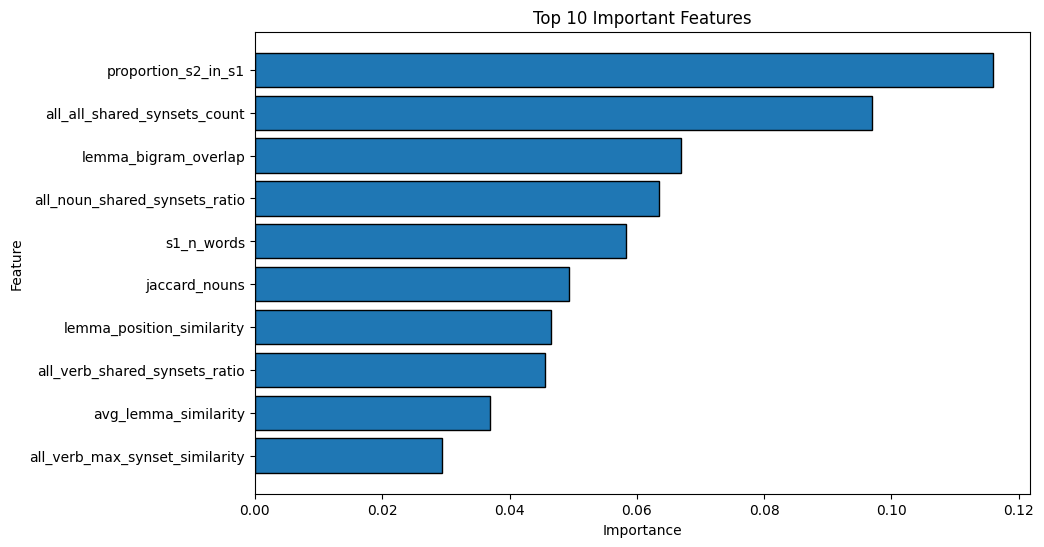


Pearson correlation for the best RF model: 0.7610017636453011
Computing mean Pearson correlation for 10 iterations...
Mean Pearson correlation over 10 iterations: 0.7626539074321047
Predicted data saved to CSV: ../data/test/03_predicted/2024-12-10_16-27-26_predicted_rf_all_predicted_test_data.csv
Predicted data saved to Excel: ../data/test/03_predicted/2024-12-10_16-27-26_predicted_rf_all_predicted_test_data.xlsx


In [102]:
best_rf_model_all, rf_params_all, correlation_rf_all, mean_correlation_rf_all = evaluate_rf_model(
    model_trainer, 
    df_train_trimmed, 
    df_test_trimmed, 
    all_features, 
    'gs', 
    PREDICTED_SAVE_PATH,
    "predicted_rf_all"
)

### Evaluation of Additional Models

#### NN Model

In [28]:
# Train the best NN model using all features
best_nn_model = model_trainer.train_NN(df_train, all_features, 'gs')

# Predict the test data
df_test['predicted_nn'] = best_nn_model.predict(df_test[all_features])

# Calculate the Pearson correlation for the best NN model
correlation_nn = pearsonr(df_test['gs'], df_test['predicted_nn'])[0]
print(f'\n Pearson correlation for the best NN model: {correlation_nn}')

# Save the predictions
save_predictions(df_test, PREDICTED_SAVE_PATH, 'predicted_nn_all.csv')

Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\Kacpe\Desktop\College Work\Repos\Intro to HLT\Work\Labs\project\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Parameters: {'batch_size': 16, 'epochs': 100, 'model__hidden_layers': 2, 'model__learning_rate': 0.001, 'model__neurons': 10}

 Pearson correlation for the best NN model: 0.6998561595755382
Predicted data saved to CSV: ../data/test/03_predicted/2024-12-10_11-18-48_predicted_nn_all.csv_predicted_test_data.csv
Predicted data saved to Excel: ../data/test/03_predicted/2024-12-10_11-18-48_predicted_nn_all.csv_predicted_test_data.xlsx


#### MLP Model

In [21]:
# Train the best MLP model using all features
best_mlp_model = model_trainer.train_MLP(df_train, all_features, 'gs')

# Predict the test data
df_test['predicted_mlp'] = best_mlp_model.predict(df_test[all_features])

# Calculate the Pearson correlation for the best NN model
correlation_mlp = pearsonr(df_test['gs'], df_test['predicted_mlp'])[0]
print(f'\n Pearson correlation for the best MLP model: {correlation_mlp}')

# Save the predictions
save_predictions(df_test, PREDICTED_SAVE_PATH, 'predicted_mlp_all.csv')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Hyperparameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 500, 'solver': 'adam'}

 Pearson correlation for the best MLP model: 0.711672456928118
Predicted data saved to CSV: ../data/test/03_predicted/2024-12-10_11-07-41_predicted_mlp_all.csv_predicted_test_data.csv
Predicted data saved to Excel: ../data/test/03_predicted/2024-12-10_11-07-41_predicted_mlp_all.csv_predicted_test_data.xlsx


#### SVR Model

In [22]:
# Train the best SVR model using all features
best_svr_model = model_trainer.train_SVR(df_train, all_features, 'gs')

# Predict the test data
df_test['predicted_svr'] = best_svr_model.predict(df_test[all_features])

# Calculate the Pearson correlation for the best SVR model
correlation_svr = pearsonr(df_test['gs'], df_test['predicted_svr'])[0]
print(f'\n Pearson correlation for the best SVR model: {correlation_svr}')

# Save the predictions
save_predictions(df_test, PREDICTED_SAVE_PATH, 'predicted_svr_all.csv')

c:\Users\Kacpe\Desktop\College Work\Repos\Intro to HLT\Work\Labs\project\venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}


c:\Users\Kacpe\Desktop\College Work\Repos\Intro to HLT\Work\Labs\project\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(



 Pearson correlation for the best SVR model: -0.16273316207516741
Predicted data saved to CSV: ../data/test/03_predicted/2024-12-10_11-08-25_predicted_svr_all.csv_predicted_test_data.csv
Predicted data saved to Excel: ../data/test/03_predicted/2024-12-10_11-08-25_predicted_svr_all.csv_predicted_test_data.xlsx


## Additional Code (TODO: Discuss if we're keeping this)

### Compare correlation based on file and features

In [ ]:
N_ITERS = 10
# Train a Random Forest for each feature set and each file set
for t_name, tr_set, vl_set in files_sets:
    print()
    for f_name, f_set in features_sets:
        train = df_train[df_train['file'].isin(tr_set)]
        
        test = df_test[df_test['file'].isin(tr_set)]
        corr = 0
        for i in range(N_ITERS):
            model = train_single_RF(train, f_set, 'gs', params)
            test.loc[:, 'predicted'] = model.predict(test[f_set])
            corr += pearsonr(test['gs'], test['predicted'])[0]
        print(f_name, t_name, corr / N_ITERS)

        test = df_test[df_test['file'].isin(vl_set)]
        corr = 0
        for i in range(N_ITERS):
            model = train_single_RF(train, f_set, 'gs', params)
            test.loc[:, 'predicted'] = model.predict(test[f_set])
            corr += pearsonr(test['gs'], test['predicted'])[0]
        print(f_name, t_name, corr / N_ITERS, '(with surprise files)')



All SMTeuroparl 0.5260762425283135
All SMTeuroparl 0.6321408221170948 (with surprise files)
Synsets SMTeuroparl 0.5089847580757192
Synsets SMTeuroparl 0.5984333819281736 (with surprise files)
Lemmas SMTeuroparl 0.48728005311908856
Lemmas SMTeuroparl 0.5838403729608709 (with surprise files)
PoS (Syntactical) SMTeuroparl 0.28082396513890506
PoS (Syntactical) SMTeuroparl 0.3062866488678532 (with surprise files)
Lexical SMTeuroparl 0.5317844394052379
Lexical SMTeuroparl 0.6256457418945189 (with surprise files)

All MSRvid 0.8611804247098516
All MSRvid 0.7915275196347473 (with surprise files)
Synsets MSRvid 0.8597524788987414
Synsets MSRvid 0.7654246344934643 (with surprise files)
Lemmas MSRvid 0.6572899927033499
Lemmas MSRvid 0.6420521699471147 (with surprise files)
PoS (Syntactical) MSRvid 0.20808034566065797
PoS (Syntactical) MSRvid 0.35248343346031863 (with surprise files)
Lexical MSRvid 0.8620913345693634
Lexical MSRvid 0.7776658207000915 (with surprise files)

All MSRpar 0.5980055133

### Is it possible to predict separating by source file?

In [ ]:
from keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Get a filtered test set
filt_df_test = df_test[df_test['file'].isin(all_train_files)].copy()

# Encode the file column to numerical labels
label_encoder = LabelEncoder()
df_train['file_encoded'] = label_encoder.fit_transform(df_train['file'])
filt_df_test.loc[:, 'file_encoded'] = label_encoder.transform(filt_df_test['file'])

# On the train set, do a categorical encoding for the file column
y_train = to_categorical(df_train['file_encoded'], num_classes=len(all_train_files))
# Filter the test dataset and do the categorical encoding
filt_y_test = to_categorical(filt_df_test['file_encoded'], num_classes=len(all_train_files))

# Create a random forest classification model from df_train to y_train
clf = RandomForestClassifier(n_estimators=100)

# Train the model
clf.fit(df_train[all_features], y_train)

# Predict on the test set
y_pred = clf.predict(filt_df_test[all_features])

# Evaluate the model
accuracy = np.mean(np.argmax(filt_y_test, axis=1) == np.argmax(y_pred, axis=1))
print('Accuracy in predicting file:', accuracy)

# In the global train_set, assign the predicted file classç
print(np.argmax(clf.predict(df_train[all_features]), axis=1))
df_train['pred_file'] = np.argmax(clf.predict(df_train[all_features]), axis=1)

# Train a regression random forest for each partition of df_train based on pred_file
partitioned_models = []
for file_class in range(len(all_train_files)):
    partition = df_train[df_train['pred_file']== file_class]
    print("Number of rows in partition ", file_class, ":", partition.shape[0])
    if not partition.empty:
        print("One model")
        model, params = train_RF(partition, all_features, 'gs')
        # model = RandomForestRegressor(**params)
        # model.fit(partition[all_features], partition['gs'])
        partitioned_models.append(model)

# For each row in df_test, predict the file class and use the corresponding model to predict the predicted_gs
# Predict the file class for each row in df_test
df_test['pred_file'] = np.argmax(clf.predict(df_test[all_features]), axis=1)

# For each partition of df_test based on pred_file, use the corresponding model to predict the gs
for fcls in range(len(all_train_files)):
    pred_gs = partitioned_models[fcls].predict(df_test[df_test['pred_file'] == fcls][all_features])
    print("Predicted len: ", len(pred_gs))
    df_test.loc[df_test['pred_file'] == fcls, 'gs_predicted'] = pred_gs

# Compute the pearson correlation
final_corr = pearsonr(df_test['gs'], df_test['gs_predicted'])[0]
print("Final correlation: ", final_corr)

Accuracy in predicting file: 0.8249106687085248
[2 2 2 ... 0 0 0]
Number of rows in partition  0 : 750
One model
Fitting 5 folds for each of 96 candidates, totalling 480 fits


d:\projects\MAI\IHLT\Intro-to-IHLT-Labs\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Number of rows in partition  1 : 750
One model
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Number of rows in partition  2 : 734
One model
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Predicted len:  1454
Predicted len:  1354
Predicted len:  300
Final correlation:  0.7283554075731684


## Result Analysis

Result analysis to go here. This could go into a separate file (notebook or .md file)

## Conclusion

Conclusion to go here. This could go into a separate file (notebook or .md file)